In [43]:
# import modules
import random
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from pathlib import Path
import os
cwd = os.getcwd()
import statsmodels.stats.moment_helpers
from datetime import datetime
import multiprocessing as mp
import csv
import networkx as nx

# Setup

## Parameters

In [44]:
iterations=1000
nnodes=100
p_link=.1 
leak=.75 #works well
lrate_wmat=.1
lrate_targ=.01
targ_min=1

## Set up inputs

In [45]:
input_keys=['man_s','dog_s','walks_v','bites_v','dog_o','man_o','_']
input_dict = {
    'man_s':    [1,0,0,0,0],
    'dog_s':    [0,1,0,0,0],
    'walks_v':  [0,0,1,0,0],
    'bites_v':  [0,0,0,1,0],
    'dog_o':    [0,1,0,0,0],
    'man_o':    [1,0,0,0,0],
    '_':        [0,0,0,0,1]
}

grammarmat=np.zeros( (7, 7) )
grammarmat[0,2] = .75; grammarmat[0,3]=.25;
grammarmat[1,2] = .25; grammarmat[1,3]=.75;
grammarmat[2,4] = .75; grammarmat[2,5]=.25;
grammarmat[3,4] = .25; grammarmat[3,5]=.75;
grammarmat[4,6] = 1; 
grammarmat[5,6] = 1; 
grammarmat[6,0] = .5; grammarmat[6,1]=.5;
        
input_wmat=np.zeros((5,nnodes))
for row in range(input_wmat.shape[0]):
    for col in range(nnodes):
        input_wmat[row,col]=random.choices([0,5], weights=(1-p_link,p_link), k=1)[0]

## Set up internal weight matrix

In [46]:
link_mat = np.zeros((nnodes,nnodes))
for row in range(link_mat.shape[0]):
    for col in range(link_mat.shape[1]):
        if row == col:
            continue
        link_mat[row,col] = random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]
# link_mat[:,:]=1
# np.fill_diagonal(link_mat,0)
        
wmat=np.zeros((nnodes,nnodes))
for row in range(wmat.shape[0]):
    for col in range(wmat.shape[1]):
        if link_mat[row,col] == 1:
            wmat[row,col] = np.random.normal(0,1)
            
start_wmat=wmat.copy()

## Functions

In [47]:
def choose_next_input(i,t,input_key):
    index1=input_keys.index(input_key)
    input_key = random.choices(input_keys,weights=grammarmat[input_keys.index(input_key)])[0]
    index2=input_keys.index(input_key)

    tprob=grammarmat[index1,index2]
    
    input = input_dict[input_key]
        
    return input, input_key, tprob


def get_acts(acts,leak,spikes,wmat,input,input_wmat,targets):
    acts = acts*leak + np.dot(input, input_wmat) + np.dot(spikes, wmat)
    
    thresholds = targets*2
    spikes[acts >= thresholds]=1
    spikes[acts < thresholds]=0
    
    acts[spikes==1]=acts[spikes==1]-thresholds[spikes==1]
    acts[acts<0]=0
       
    errors=acts-targets
    
    return acts, spikes, errors

def learning(learn_on,link_mat,prev_spikes, errors,wmat,targets):
    prev_active= np.argwhere(prev_spikes > 0)[:,0]
    prev_inactive = np.argwhere(prev_spikes<=0)[:,0]
    
    active_neighbors=link_mat.copy()
    active_neighbors[prev_inactive,:]=0
    active_neighbors=np.sum(active_neighbors,axis=0)#+np.repeat(1,nnodes)
    
    if learn_on==1:
        d_wmat = np.zeros((nnodes,nnodes))
        d_wmat[:,:]=errors*lrate_wmat
        d_wmat[link_mat==0]=0
        d_wmat[prev_inactive,:]=0
        d_wmat=(d_wmat/active_neighbors)
        d_wmat=np.nan_to_num(d_wmat)
        wmat-=d_wmat
        
        targets=targets+(errors*lrate_targ)
        targets[targets<targ_min]=targ_min
        
    return wmat, targets

# Run the model

In [48]:
start_spikes=pd.DataFrame()
start_acts=pd.DataFrame()
start_targets=pd.DataFrame()
start_stream=pd.DataFrame()
start_errors=pd.DataFrame()
start_tprobs=pd.DataFrame()

end_spikes=pd.DataFrame()
end_acts=pd.DataFrame()
end_targets=pd.DataFrame()
end_stream=pd.DataFrame()
end_errors=pd.DataFrame()
end_tprobs=pd.DataFrame()

spikes=np.zeros(nnodes)
targets=np.repeat(targ_min,nnodes)
acts=np.zeros(nnodes)

input_key = '_'

i=1
t=0
learn_on=1
while i <= iterations:
    t+=1
        
    input, input_key, tprob = choose_next_input(i,t,input_key)
    
            
    if ((i >= iterations-8) & (t==1)):
        grammarmat=np.zeros( (7, 7) )
        grammarmat[0,2] = .75; grammarmat[0,3]=.25;
        grammarmat[1,2] = .25; grammarmat[1,3]=.75;
        grammarmat[2,4] = .75; grammarmat[2,5]=.25;
        grammarmat[3,4] = .25; grammarmat[3,5]=.75;
        grammarmat[4,6] = 1; 
        grammarmat[5,6] = 1; 
        grammarmat[6,0] = .5; grammarmat[6,1]=.5;
        if end_stream.iloc[-4][0]=='man_s':
            input_key='dog_s'
            input=input_dict[input_key]
        elif end_stream.iloc[-4][0]=='dog_s':
            input_key='man_s'
            input=input_dict[input_key]
            
    if ((i >1) & (i<=8) & (t==1)):
        if start_stream.iloc[-4][0]=='man_s':
            input_key='dog_s'
            input=input_dict[input_key]
        elif start_stream.iloc[-4][0]=='dog_s':
            input_key='man_s'
            input=input_dict[input_key]
        
    prev_spikes = spikes.copy()
    
    acts, spikes, errors = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)
    
    if((i % 1000 ==0) & (t ==1)):
        print(' ')
    if (i % 1000 ==0) | (i == 1):
        ME = errors.mean()
        print('iteration: ', i, ' ; time: ', t,' ; ME: ',ME)
    
    wmat, targets = learning(learn_on,link_mat,prev_spikes, errors, wmat,targets)
        
    if i <= 4:
        start_spikes=start_spikes.append([spikes],ignore_index=True)
        start_acts=start_acts.append([acts],ignore_index=True)
        start_errors=start_errors.append([errors],ignore_index=True)
        start_tprobs=start_tprobs.append([tprob],ignore_index=True)
        start_targets=start_targets.append([targets], ignore_index=True)
        start_stream=start_stream.append([input_key],ignore_index=True)
    if i > iterations -100:
        end_spikes=end_spikes.append([spikes],ignore_index=True)
        end_acts=end_acts.append([acts],ignore_index=True)
        end_errors=end_errors.append([errors],ignore_index=True)
        end_stream=end_stream.append([input_key],ignore_index=True)
        end_tprobs=end_tprobs.append([tprob],ignore_index=True)
        end_targets=end_targets.append([targets], ignore_index=True)
            
    if t == 4:
        t=0
        i+=1
            
end_wmat=wmat.copy()
    
start_errors.mean(axis=1).to_csv('start_errors.csv')
start_stream.to_csv('start_stream.csv')
start_tprobs.to_csv('start_tprobs.csv')
start_spikes.sum(axis=1).to_csv('start_spikes_sum.csv')
start_spikes.to_csv('start_spikes.csv')

end_errors.mean(axis=1).to_csv('end_errors.csv')
end_stream.to_csv('end_stream.csv')
end_tprobs.to_csv('end_tprobs.csv')
end_spikes.sum(axis=1).to_csv('end_spikes_sum.csv') 
end_spikes.to_csv('end_spikes.csv') 

iteration:  1  ; time:  1  ; ME:  -0.7
iteration:  1  ; time:  2  ; ME:  -0.2913498916701782
iteration:  1  ; time:  3  ; ME:  0.016290954276507993
iteration:  1  ; time:  4  ; ME:  0.10466288054594441


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


 
iteration:  1000  ; time:  1  ; ME:  -0.017420003856109402
iteration:  1000  ; time:  2  ; ME:  -0.06919532461524669
iteration:  1000  ; time:  3  ; ME:  -0.0838097934324126
iteration:  1000  ; time:  4  ; ME:  -0.023021393599584064


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: Fut

# Plotting

### Functions

In [30]:
import matplotlib.transforms

def plot_raster_plot(end_spikes, end_stream, test_spikes,test_stream,input_key,first_input, input_num):
    plot_spikes=np.array(end_spikes.iloc[-12:,:])
    plot_spikes=np.vstack((plot_spikes,test_spikes))
    plot_spikes[12:17,][plot_spikes[12:17,]==0]=-1
    plot_spikes=np.transpose(plot_spikes)

    fig, ax = plt.subplots()

    colors = cm.get_cmap('RdYlBu', 4)
    newcolors = colors([4,1,2])
    newcolors = np.array([[2/255, 2/255, 237/255,1],[237/255, 2/255, 2/255,1],[237/255, 237/255, 2/255,1]])
    newcmp = ListedColormap(newcolors)

    im = ax.pcolormesh(plot_spikes,cmap=newcmp)

    ax.set_xticks(np.arange(16))
    ax.set_yticks(np.arange(nnodes))
    ax.set_xticklabels(np.append(np.array(end_stream.iloc[-12:,:])[:,0],test_stream).tolist())
    #ax.set_yticklabels()
    ax.axes.yaxis.set_ticklabels([])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Create offset transform by 5 points in x direction
    dx = 15/72.; dy = 0/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

    # apply offset transform to all x ticklabels.
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)

    plt.grid()   

    name='Fig3.'+ str(input_keys[first_input]) + '.' + str(input_num) +'.png'
   
    fig.tight_layout()
    fig.set_size_inches(12, 8)
    fig.savefig(name, dpi=300)

    plt.show()

def plot_cor_matrix(end_spikes, end_stream, test_spikes,test_stream,input_key,first_input, input_num):
    plot_spikes=np.array(end_spikes.iloc[-12:,:])
    plot_spikes=np.vstack((plot_spikes,test_spikes))
    cor_matrix = np.zeros((16,16))
    for n in range(16):
        x = plot_spikes[n,:]
        for r in range(16):
            if (r >= n):  
                y = plot_spikes[r,:]
                res = np.around(scipy.stats.pearsonr(x, y)[0],2)
                cor_matrix[r,n]=res
            else:
                cor_matrix[r,n] = np.nan

    cmap = cm.get_cmap('RdYlBu', 7)

    fig, ax = plt.subplots()
    im = ax.imshow(cor_matrix,cmap=cmap)

    ax.set_xticks(np.arange(16))
    ax.set_yticks(np.arange(16))

    ax.set_xticklabels(np.append(np.array(end_stream.iloc[-12:,:])[:,0],test_stream).tolist())
    ax.set_yticklabels(np.append(np.array(end_stream.iloc[-12:,:])[:,0],test_stream).tolist())

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(16):
        for j in range(16):
            if j > i:
                continue
            text = ax.text(j, i, cor_matrix[i, j],
                           ha="center", va="center", color="black")

    name='Fig4.'+ str(input_keys[first_input]) + '.' + str(input_num) +'.png'


    plt.colorbar(im, ax=ax)
    im.set_clim(-1, 1)
    fig.tight_layout()
    fig.set_size_inches(18.75, 15)
    fig.savefig(name, dpi=300)
    
    plt.show()

## start of run

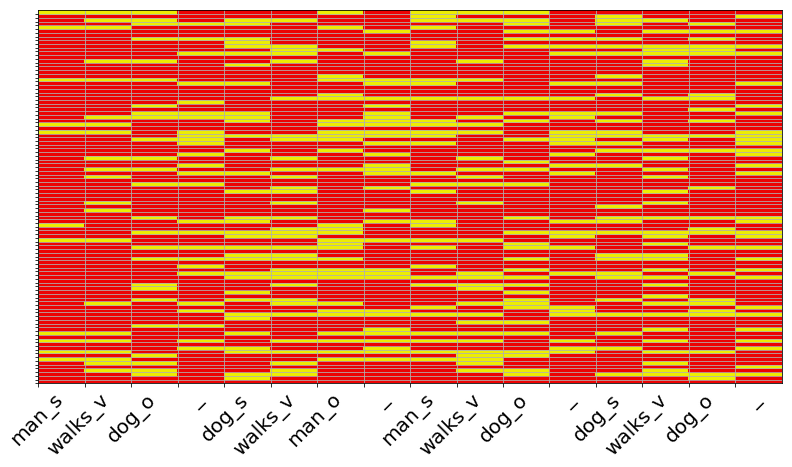

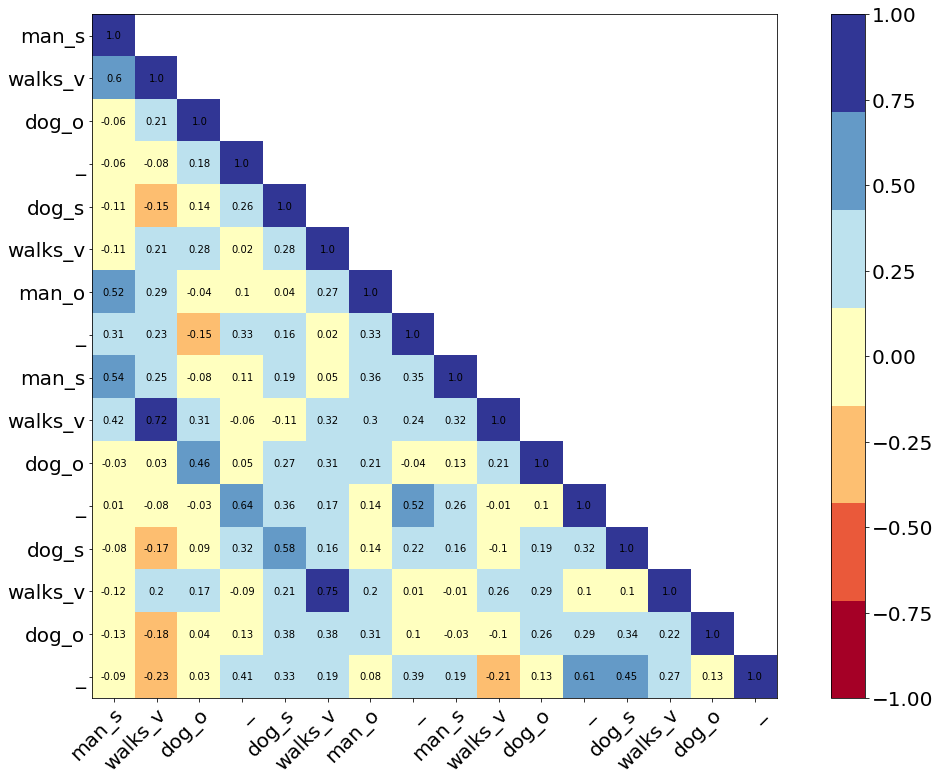

In [31]:
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

plot_spikes=np.array(start_spikes.iloc[0:16,:])
plot_spikes=np.transpose(plot_spikes)

fig, ax = plt.subplots()

colors = cm.get_cmap('RdYlBu', 4)
newcolors = colors([4,1,2])
newcolors = np.array([[237/255, 2/255, 2/255,1],[237/255, 237/255, 2/255,1]])
newcmp = ListedColormap(newcolors)

im = ax.pcolormesh(plot_spikes,cmap=newcmp) 

ax.set_xticks(np.arange(16))
ax.set_yticks(np.arange(nnodes))
ax.set_xticklabels(np.array(start_stream.iloc[0:16,:])[:,0])
#ax.set_yticklabels()
ax.axes.yaxis.set_ticklabels([])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", va="top",
         rotation_mode="anchor")

# Create offset transform by 5 points in x direction
dx = 15/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

plt.grid()


name='Fig1.png'


fig.tight_layout()
fig.set_size_inches(12, 8)
fig.savefig(name, dpi=300)

plt.show()

#####

plot_spikes=np.array(start_spikes.iloc[0:16,:])
cor_matrix = np.zeros((16,16))
for n in range(16):
    x = plot_spikes[n,:]
    for r in range(16):
        if (r >= n):  
            y = plot_spikes[r,:]
            res = np.around(scipy.stats.pearsonr(x, y)[0],2)
            cor_matrix[r,n]=res
        else:
            cor_matrix[r,n] = np.nan

cmap = cm.get_cmap('RdYlBu', 7)

fig, ax = plt.subplots()
im = ax.imshow(cor_matrix,cmap=cmap)

ax.set_xticks(np.arange(16))
ax.set_yticks(np.arange(16))

ax.set_xticklabels(np.array(start_stream.iloc[0:16,:])[:,0])
ax.set_yticklabels(np.array(start_stream.iloc[0:16,:])[:,0])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(16):
    for j in range(16):
        if j > i:
            continue
        text = ax.text(j, i, cor_matrix[i, j],
                       ha="center", va="center", color="black")

name='Fig2.png'

plt.colorbar(im, ax=ax)

im.set_clim(-1, 1)
fig.tight_layout()
fig.set_size_inches(18.75, 15)
fig.savefig(name, dpi=300)

plt.show()


## end of run

first input:  0  ; input_num:  1  ; time:  1  ; MAE:  0.31324737333897
first input:  0  ; input_num:  1  ; time:  2  ; MAE:  0.28563109326787667
first input:  0  ; input_num:  1  ; time:  3  ; MAE:  0.3459055851165981
first input:  0  ; input_num:  1  ; time:  4  ; MAE:  0.5105717694534069


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


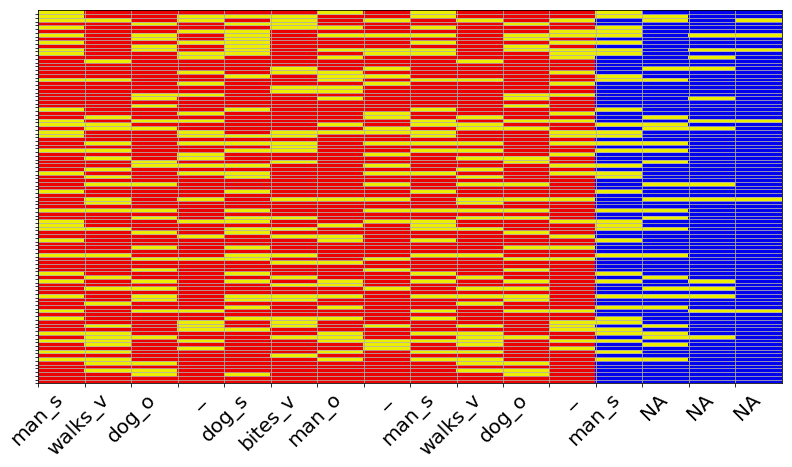

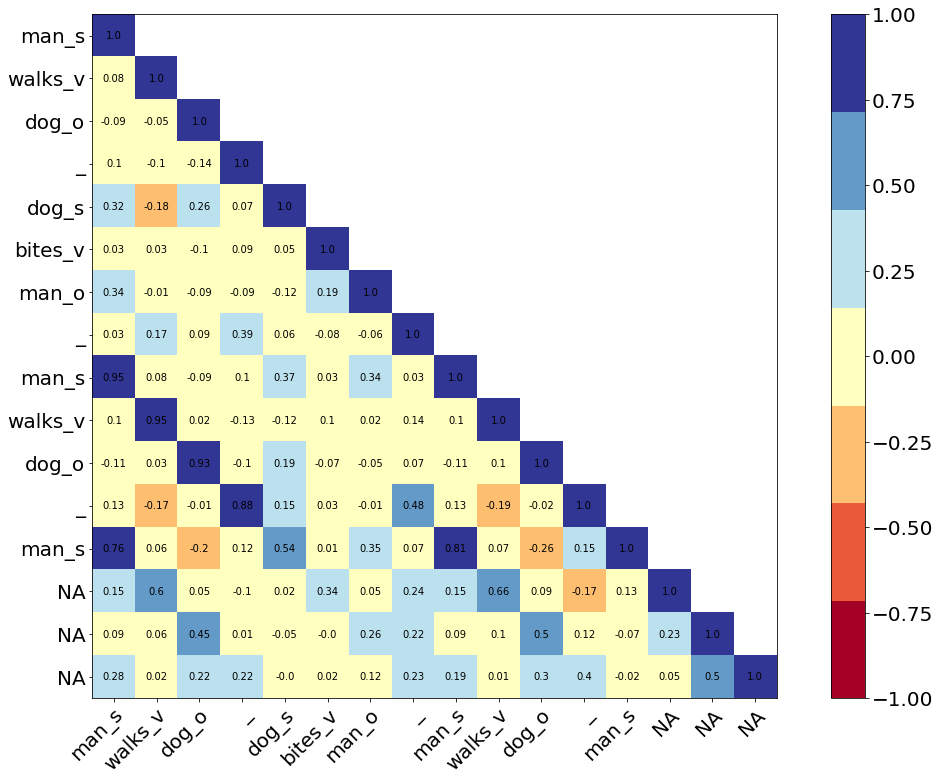

first input:  0  ; input_num:  2  ; time:  1  ; MAE:  0.3079666141239303
first input:  0  ; input_num:  2  ; time:  2  ; MAE:  0.2623517230622143
first input:  0  ; input_num:  2  ; time:  3  ; MAE:  0.22770205191401707
first input:  0  ; input_num:  2  ; time:  4  ; MAE:  0.36433983766156663


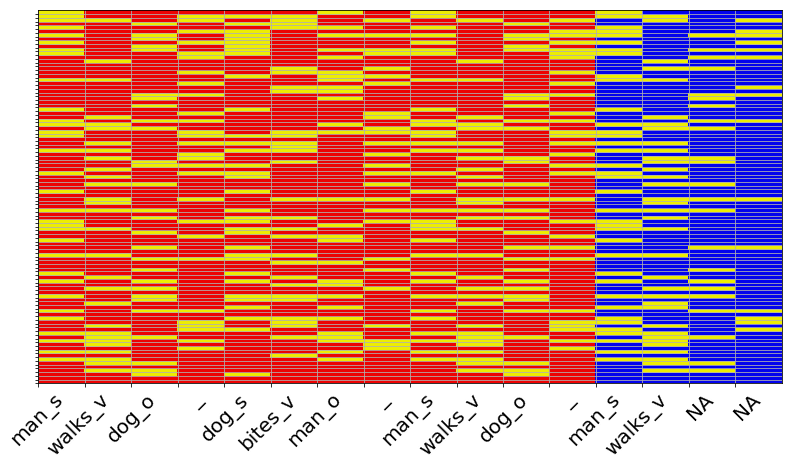

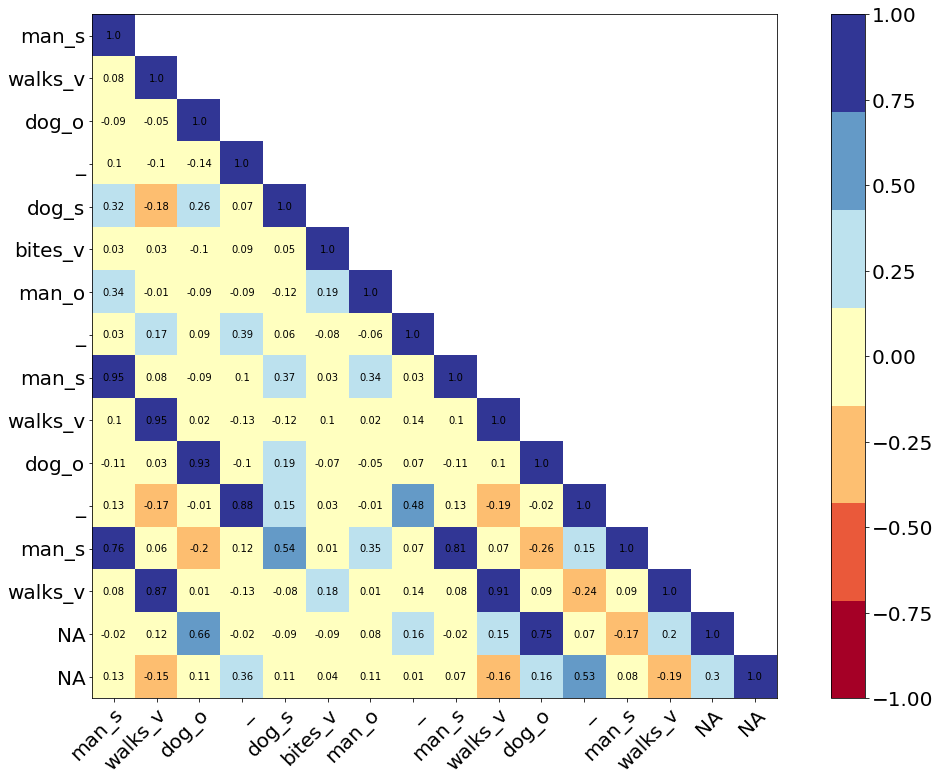

first input:  1  ; input_num:  1  ; time:  1  ; MAE:  0.25765746761746755
first input:  1  ; input_num:  1  ; time:  2  ; MAE:  0.27238153378199464
first input:  1  ; input_num:  1  ; time:  3  ; MAE:  0.3305386203548011
first input:  1  ; input_num:  1  ; time:  4  ; MAE:  0.49908159488048126


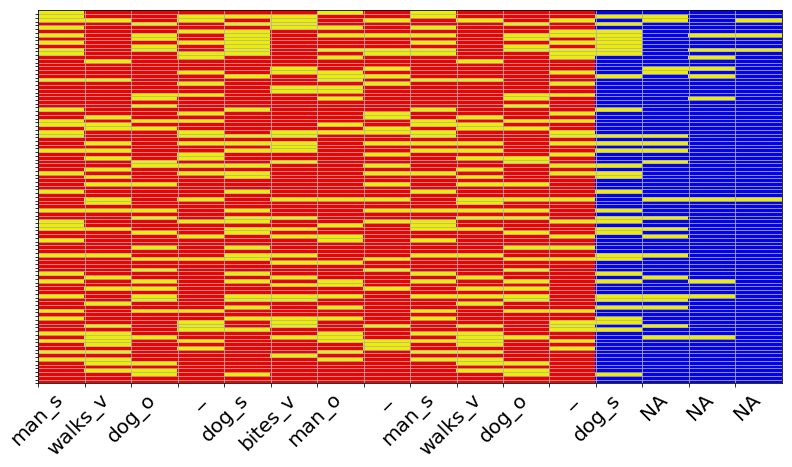

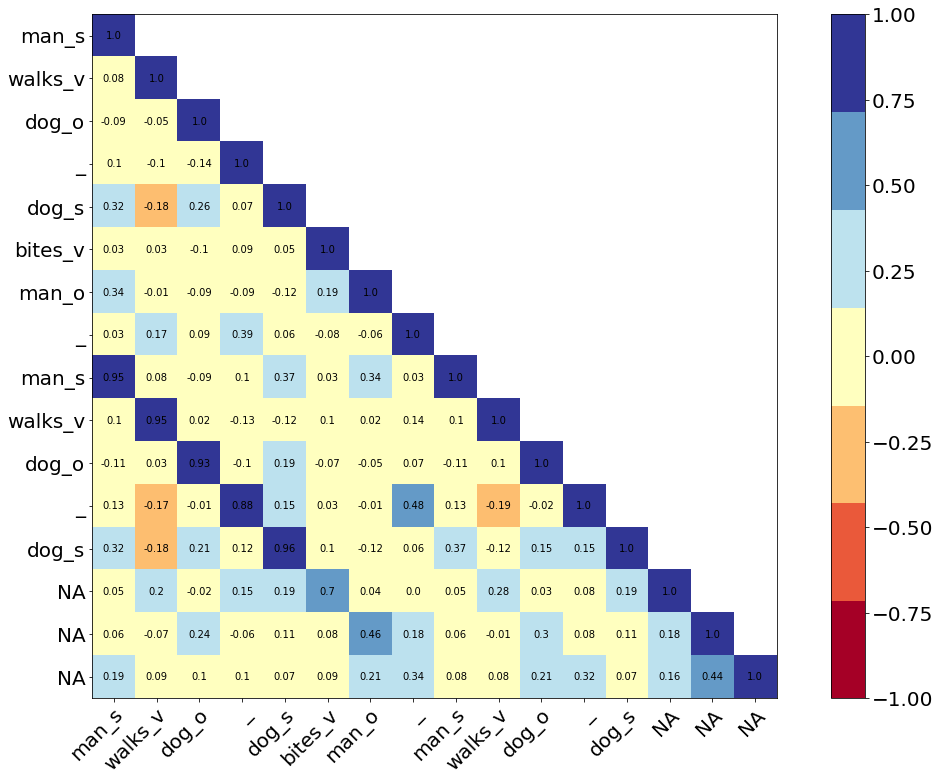

first input:  1  ; input_num:  2  ; time:  1  ; MAE:  0.2550267949901103
first input:  1  ; input_num:  2  ; time:  2  ; MAE:  0.2750060251498318
first input:  1  ; input_num:  2  ; time:  3  ; MAE:  0.2397821565153069
first input:  1  ; input_num:  2  ; time:  4  ; MAE:  0.3867129997049428


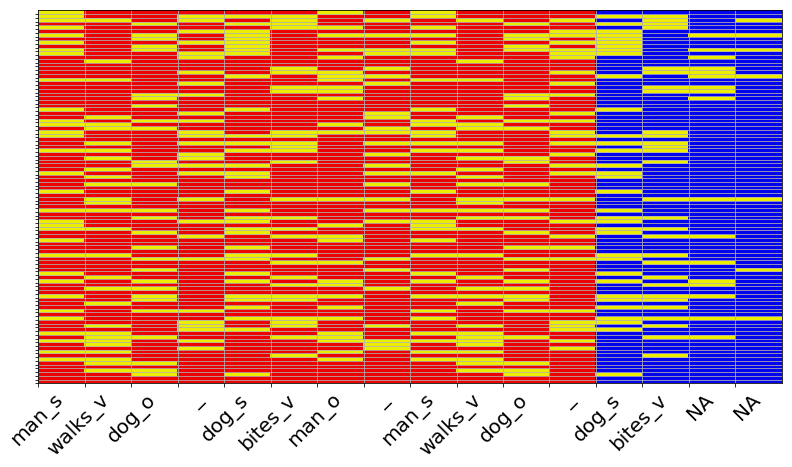

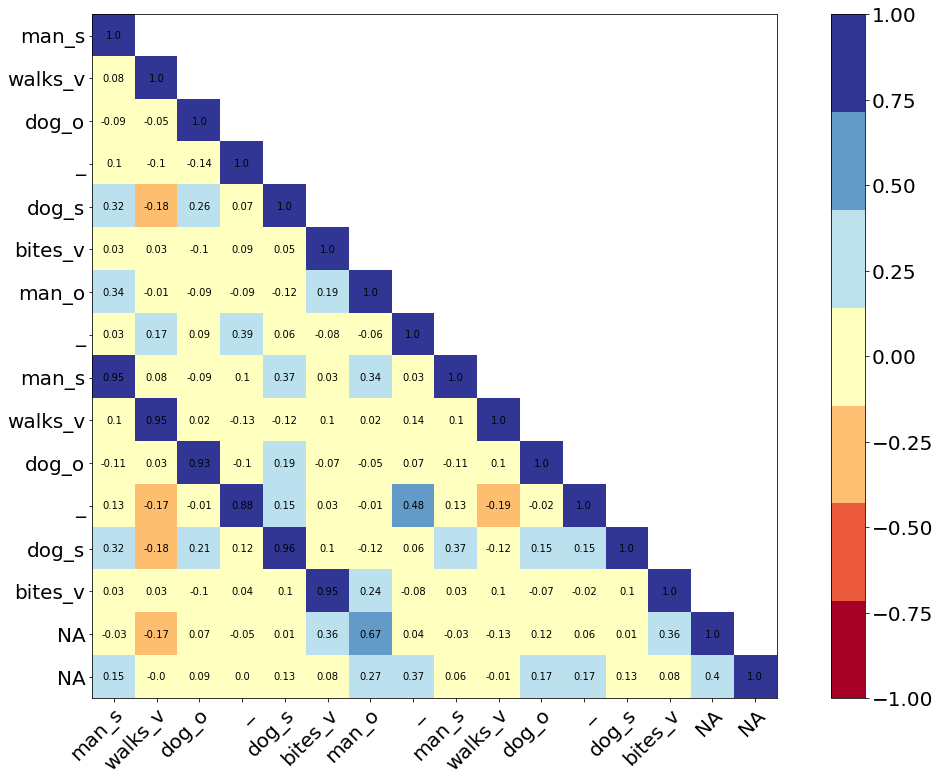

In [32]:
grammarmat=np.zeros( (7, 7) )
grammarmat[0,2] = 1; grammarmat[0,3]=0;
grammarmat[1,2] = 0; grammarmat[1,3]=1;
grammarmat[2,4] = 1; grammarmat[2,5]=0;
grammarmat[3,4] = 0; grammarmat[3,5]=1;
grammarmat[4,6] = 1; 
grammarmat[5,6] = 1; 
grammarmat[6,0] = .5; grammarmat[6,1]=.5;

learn_on = 1
for first_input in range(0,2):
    for input_num in range(1,3):
        
        test_spikes=pd.DataFrame()
        test_acts=pd.DataFrame()
        test_stream=pd.DataFrame()
        test_errors=pd.DataFrame()
        
        spikes=np.array(end_spikes.iloc[end_spikes.shape[0]-1,:])
            
        acts=np.array(end_acts.iloc[end_acts.shape[0]-1,:])       
        wmat=end_wmat.copy()
        
        t=0
        on=True
        while on==True:
            t+=1
            
            if t ==1:
                input_key = input_keys[first_input]
                input = input_dict[input_key]
            else:
                input_key = random.choices(input_keys,weights=grammarmat[input_keys.index(input_key)])[0]
                input = input_dict[input_key]

            prev_spikes = spikes.copy()
            
            if t >input_num:
                input=[0,0,0,0,0]

            acts, spikes, errors = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)

            MAE = abs(errors).mean()
            print('first input: ', first_input,' ; input_num: ',input_num, ' ; time: ', t,' ; MAE: ',MAE)

            wmat,targets = learning(learn_on,link_mat,prev_spikes, errors,wmat,targets)
            
            test_spikes=test_spikes.append([spikes])
            test_acts=test_acts.append([acts])
            test_errors=test_errors.append([errors])
            if t > input_num:
                test_stream=test_stream.append(['NA'])
            else:
                test_stream=test_stream.append([input_key])

            if t == 4:
                on=False
                
        plot_raster_plot(end_spikes, end_stream, test_spikes,test_stream,input_key,first_input, input_num)
        plot_cor_matrix(end_spikes, end_stream, test_spikes,test_stream,input_key,first_input, input_num) 

# how long does fading memory last?

In [50]:
test_spikes=pd.DataFrame()
test_acts=pd.DataFrame()
test_stream=pd.DataFrame()
test_errors=pd.DataFrame()

spikes=np.array(end_spikes.iloc[end_spikes.shape[0]-1,:])

acts=np.array(end_acts.iloc[end_acts.shape[0]-1,:])       
wmat=end_wmat.copy()

t=0
on=True
while on==True:
    t+=1

    if t ==1:
        input_key = input_keys[1]
        input = input_dict[input_key]
    else:
        input=[0,0,0,0,0]

    acts, spikes, errors = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)

    MAE = abs(errors).mean()
    print('first input: ', first_input,' ; input_num: ',input_num, ' ; time: ', t,' ; MAE: ',MAE)

    wmat,targets = learning(learn_on,link_mat,prev_spikes, errors,wmat,targets)

    test_spikes=test_spikes.append([spikes])
    test_acts=test_acts.append([acts])
    test_errors=test_errors.append([errors])

    if spikes.sum()==0:
        on=False

first input:  1  ; input_num:  2  ; time:  1  ; MAE:  0.3106268123731709
first input:  1  ; input_num:  2  ; time:  2  ; MAE:  0.31862658224274065
first input:  1  ; input_num:  2  ; time:  3  ; MAE:  0.4207013933236306
first input:  1  ; input_num:  2  ; time:  4  ; MAE:  0.536802246281228
first input:  1  ; input_num:  2  ; time:  5  ; MAE:  0.6444189536851315
first input:  1  ; input_num:  2  ; time:  6  ; MAE:  0.7398994053670394
first input:  1  ; input_num:  2  ; time:  7  ; MAE:  0.8369648519588728
first input:  1  ; input_num:  2  ; time:  8  ; MAE:  0.8968713330860697


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
